In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import pandas as pd

# ✅ Define paths
train_path = "/content/drive/My Drive/Colab Notebooks/Train.csv"
test_path  = "/content/drive/My Drive/Colab Notebooks/Test.csv"

# ✅ Load datasets
train_df = pd.read_csv(train_path, encoding="utf-8")
test_df  = pd.read_csv(test_path, encoding="utf-8")

# ✅ Assign the main working DataFrame
df = train_df.copy()   # Use training set for feature engineering

In [16]:
# --- Robust Drop of Tweet_ID and quick sanity checks ---

# Ensure train_df exists
try:
    train_df
except NameError:
    raise NameError("train_df is not defined. Make sure you've loaded the CSV into train_df earlier.")

# Drop Tweet_ID if it exists (safe)
if 'Tweet_ID' in train_df.columns:
    train_df = train_df.drop(columns=['Tweet_ID'])
    print("Dropped column: Tweet_ID")
else:
    print("Column 'Tweet_ID' not present — nothing to drop.")

# Reset index (optional but nice after dropping)
train_df = train_df.reset_index(drop=True)

# Quick sanity prints
print("\nColumns:", train_df.columns.tolist())
print("\nSample rows:")
display(train_df.head())

# Show class distribution for the label column (detect likely label column)
label_col = None
for c in ['type', 'label', 'Type']:
    if c in train_df.columns:
        label_col = c
        break

if label_col:
    print(f"\nLabel column detected: '{label_col}'")
    print(train_df[label_col].value_counts(dropna=False))
else:
    print("\nNo obvious label column ('type' or 'label') found — please confirm the name of your label column.")


Dropped column: Tweet_ID

Columns: ['tweet', 'type']

Sample rows:


,tweet,type
0,Had a dream i got raped last night. By a guy i...,sexual_violence
1,he thought the word raped means sex and told m...,sexual_violence
2,She NOT TALKING TO ME I WAS RAPED BY 2 MEN 1 M...,sexual_violence
3,I was sexually abused for 3 years at age 4 to ...,sexual_violence
4,Chessy Prout can do better by telling the trut...,sexual_violence



Label column detected: 'type'
type
sexual_violence                 32648
Physical_violence                5946
emotional_violence                651
economic_violence                 217
Harmful_Traditional_practice      188
Name: count, dtype: int64


/tmp/ipython-input-1176916553.py:42: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


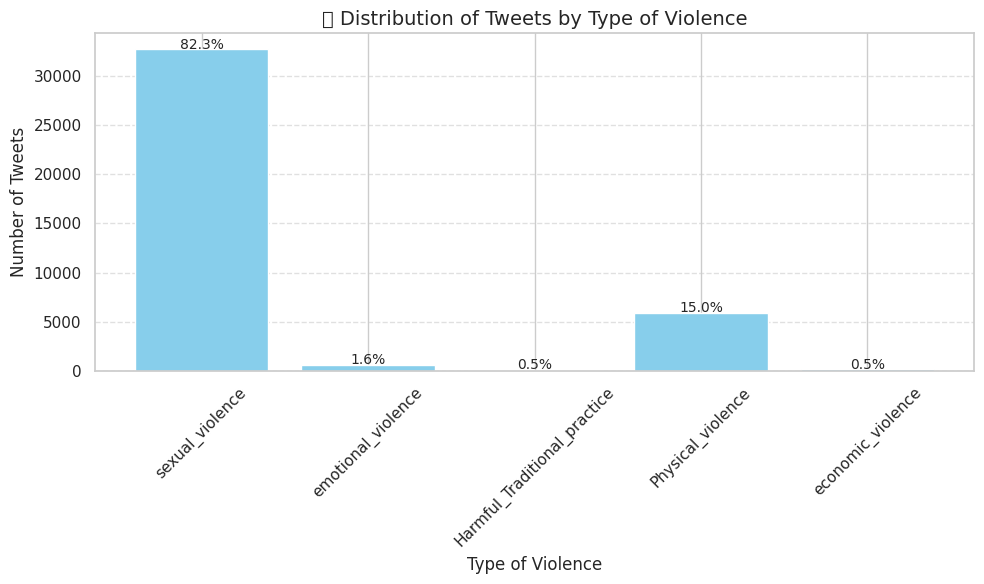

📈 Raw Counts:
type
sexual_violence                 32648
emotional_violence                651
Harmful_Traditional_practice      188
Physical_violence                5946
economic_violence                 217
Name: count, dtype: int64

📊 Percentages:
type
sexual_violence                 82.34
emotional_violence               1.64
Harmful_Traditional_practice     0.47
Physical_violence               15.00
economic_violence                0.55
Name: count, dtype: float64


In [17]:
# --- Visualize Distribution of Violence Types ---

import matplotlib.pyplot as plt

# Ensure 'type' column exists
if 'type' not in train_df.columns:
    raise KeyError("❌ Column 'type' not found in train_df. Please check your dataset.")

# Count occurrences
violence_counts = train_df['type'].value_counts()

# Define expected categories
expected_categories = [
    'sexual_violence',
    'emotional_violence',
    'Harmful_Traditional_practice',
    'Physical_violence',
    'economic_violence'
]

# Filter to only those that exist in your data
available_categories = [cat for cat in expected_categories if cat in violence_counts.index]

specified_violence_counts = violence_counts.loc[available_categories]

# Create bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(specified_violence_counts.index, specified_violence_counts.values, color='skyblue')

# Annotate percentages on top of bars
total = specified_violence_counts.sum()
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 50, f"{(yval/total)*100:.1f}%", ha='center', fontsize=10)

# Titles and labels
plt.title('📊 Distribution of Tweets by Type of Violence', fontsize=14)
plt.xlabel('Type of Violence', fontsize=12)
plt.ylabel('Number of Tweets', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Print details
print("📈 Raw Counts:")
print(specified_violence_counts)
print("\n📊 Percentages:")
print((specified_violence_counts / specified_violence_counts.sum() * 100).round(2))


In [18]:
#Print the counts for better understanding
print("Sexual Violence:", specified_violence_counts['sexual_violence'])
print("Emotional Violence:", specified_violence_counts['emotional_violence'])
print("Harmful Traditional Practice:", specified_violence_counts['Harmful_Traditional_practice'])
print("Physical Violence:", specified_violence_counts['Physical_violence'])
print("Economic Violence:", specified_violence_counts['economic_violence'])

Sexual Violence: 32648
Emotional Violence: 651
Harmful Traditional Practice: 188
Physical Violence: 5946
Economic Violence: 217


In [19]:
def clean_and_convert_text(raw_text):
    import unicodedata
    import nltk
    import string
    import contractions
    import re
    import emoji
    from nltk.stem import WordNetLemmatizer

    # Ensure nltk resources are available
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('wordnet', quiet=True)
    nltk.download('omw-1.4', quiet=True)

    # Convert UTF characters to standard ASCII
    def convert_utf(text):
        text = text.replace('\u2018', "'").replace('\u2019', "'") \
                   .replace('\u201C', '"').replace('\u201D', '"') \
                   .replace('\u2013', '-').replace('\u2014', '-')
        text = unicodedata.normalize('NFKD', text)
        text = text.encode('ascii', 'ignore')
        return text.decode('ascii')

    # Convert emojis to descriptive text (e.g., 😢 -> 'crying face')
    def emoji_to_text(text):
        return emoji.demojize(text, delimiters=(" ", " "))

    # Step 1: Normalize text
    text = convert_utf(raw_text)
    text = emoji_to_text(text)
    text = contractions.fix(text.lower())

    # Step 2: Remove URLs, mentions, hashtags, HTML tags, and numbers
    text = re.sub(r'http\S+|www\S+|@\w+|#\w+|<.*?>|\d+', '', text)

    # Step 3: Tokenize text
    words = nltk.word_tokenize(text)

    # Step 4: Remove punctuation and unwanted symbols
    words = [w for w in words if w not in string.punctuation and w not in ['---', '...', '***']]

    # Step 5: Remove stopwords (but keep 'not' to preserve negation)
    stop_words = set(nltk.corpus.stopwords.words('english')) - {'not'}
    words = [w for w in words if w.lower() not in stop_words]

    # Step 6: Lemmatize words to their base form
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(w) for w in words]

    return words


In [20]:
# ✅ Environment Setup (run once per Colab session)
!pip install emoji contractions vaderSentiment textblob better-profanity nrclex imblearn

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


INFO: pip is looking at multiple versions of nrclex to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.4/396.4 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 3.0 MB/s eta 0:00:00
  Created wheel for nrclex: filename=NRCLex-3.0.0-py3-none-any.whl size=43309 sha256=227393a72767e2d27d578e3501722264c212789959e2904838bacd60265845cd
  Stored in directory: /root/.cache/pip/wheels/1f/e8/d0/e3c3da0ef3b37ef4381dbf5c9401f3a9861a63ce221b13d8bb
Successfully built nrclex


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [21]:
!pip install contractions

In [22]:
!pip install emoji


In [23]:
import pandas as pd
import unicodedata
import string
import nltk
import contractions
import re
import emoji
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

# ----------------------------
# Text Cleaning Function
# ----------------------------
def clean_and_convert_text(raw_text):
    from nltk.stem import WordNetLemmatizer

    # Ensure NLTK resources
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('wordnet', quiet=True)
    nltk.download('omw-1.4', quiet=True)

    # Normalize UTF and punctuation
    def convert_utf(text):
        text = text.replace('\u2018', "'").replace('\u2019', "'") \
                   .replace('\u201C', '"').replace('\u201D', '"') \
                   .replace('\u2013', '-').replace('\u2014', '-')
        text = unicodedata.normalize('NFKD', text)
        return text.encode('ascii', 'ignore').decode('ascii')

    # Convert emojis to text
    text = emoji.demojize(convert_utf(raw_text), delimiters=(" ", " "))
    text = contractions.fix(text.lower())

    # Remove URLs, mentions, hashtags, HTML tags, and numbers
    text = re.sub(r'http\S+|www\S+|@\w+|#\w+|<.*?>|\d+', '', text)

    # Tokenize
    words = nltk.word_tokenize(text)

    # Remove punctuation and special chars
    words = [w for w in words if w not in string.punctuation]

    # Stopword removal (keep negations)
    stop_words = set(nltk.corpus.stopwords.words('english')) - {'not'}
    words = [w for w in words if w not in stop_words]

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(w) for w in words]

    return words

# ----------------------------
# Load and Preprocess Data
# ----------------------------
train_data_path = "/content/drive/My Drive/Colab Notebooks/Train.csv"
train_data = pd.read_csv(train_data_path)

# Clean text
train_data['cleaned_text'] = train_data['tweet'].apply(clean_and_convert_text)

# Join tokens into strings for vectorizer
X = train_data['cleaned_text'].apply(lambda x: ' '.join(map(str, x)))
y = train_data['type']

# ----------------------------
# Split and Vectorize
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(
    max_features=10000, ngram_range=(1, 2), sublinear_tf=True
)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# ----------------------------
# Handle Imbalance with SMOTE
# ----------------------------
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_vec, y_train)

# ----------------------------
# Train Naive Bayes
# ----------------------------
NB_model = MultinomialNB(alpha=0.5)
NB_model.fit(X_train_resampled, y_train_resampled)

# Evaluate
train_acc = accuracy_score(y_train_resampled, NB_model.predict(X_train_resampled))
test_acc = accuracy_score(y_test, NB_model.predict(X_test_vec))

print(f"✅ Training Accuracy: {train_acc:.2%}")
print(f"✅ Test Accuracy: {test_acc:.2%}")
print("\nClassification Report:\n")
print(classification_report(y_test, NB_model.predict(X_test_vec)))


✅ Training Accuracy: 99.68%
✅ Test Accuracy: 97.81%

Classification Report:

                              precision    recall  f1-score   support

Harmful_Traditional_practice       0.93      0.89      0.91        47
           Physical_violence       0.99      0.92      0.95      1487
           economic_violence       0.85      0.65      0.74        54
          emotional_violence       0.89      0.78      0.83       163
             sexual_violence       0.98      1.00      0.99      8162

                    accuracy                           0.98      9913
                   macro avg       0.93      0.85      0.88      9913
                weighted avg       0.98      0.98      0.98      9913



📘 Classification Report - Training Data
                              precision    recall  f1-score   support

Harmful_Traditional_practice      0.959     1.000     0.979       141
           Physical_violence      0.989     0.963     0.976      4459
           economic_violence      0.931     1.000     0.964       163
          emotional_violence      0.921     1.000     0.959       488
             sexual_violence      0.994     0.996     0.995     24486

                    accuracy                          0.991     29737
                   macro avg      0.959     0.992     0.975     29737
                weighted avg      0.991     0.991     0.991     29737

Training Accuracy: 99.11%

📘 Classification Report - Test Data
                              precision    recall  f1-score   support

Harmful_Traditional_practice      0.933     0.894     0.913        47
           Physical_violence      0.989     0.917     0.952      1487
           economic_violence      0.854     0.648    

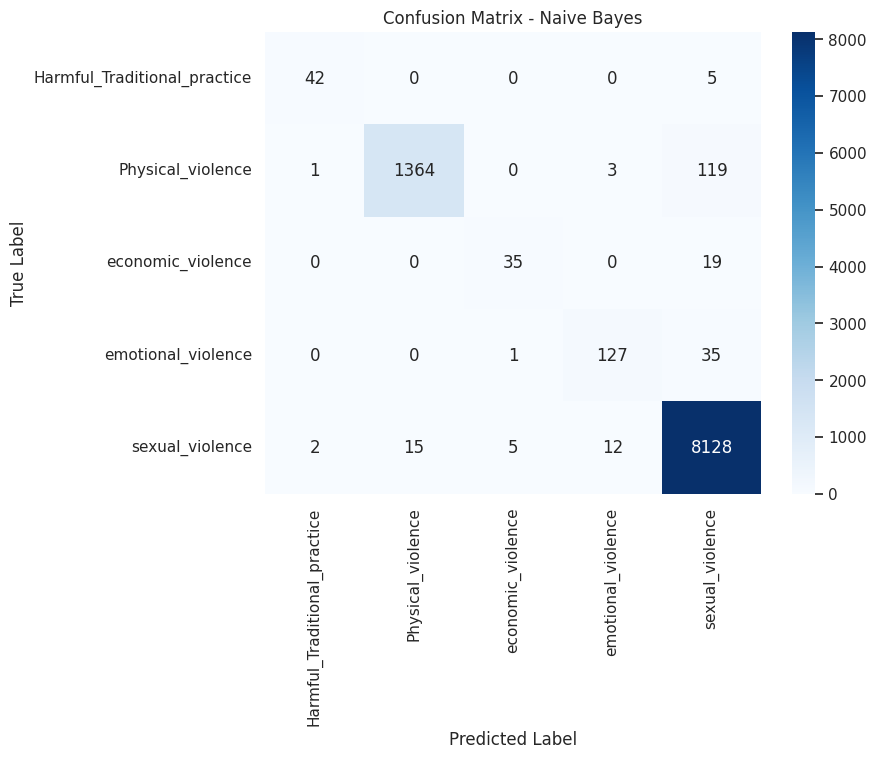

In [24]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# ----------------------------
# Evaluate Naive Bayes Model
# ----------------------------
# Training predictions
train_predictions = NB_model.predict(X_train_vec)

print("📘 Classification Report - Training Data")
print("=" * 60)
print(classification_report(y_train, train_predictions, digits=3))
print(f"Training Accuracy: {accuracy_score(y_train, train_predictions):.2%}\n")

# Test predictions
test_predictions = NB_model.predict(X_test_vec)

print("📘 Classification Report - Test Data")
print("=" * 60)
print(classification_report(y_test, test_predictions, digits=3))
print(f"Test Accuracy: {accuracy_score(y_test, test_predictions):.2%}\n")

# ----------------------------
# Confusion Matrix Visualization
# ----------------------------
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, test_predictions, labels=NB_model.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=NB_model.classes_, yticklabels=NB_model.classes_)
plt.title('Confusion Matrix - Naive Bayes')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [25]:
from joblib import dump
import os

# ----------------------------
# Save the Trained Naive Bayes Model + Vectorizer
# ----------------------------
save_dir = "/content/drive/My Drive/Colab Notebooks/Models"
os.makedirs(save_dir, exist_ok=True)

NB_model_path = os.path.join(save_dir, "naive_bayes_model.joblib")
vectorizer_path = os.path.join(save_dir, "tfidf_vectorizer.joblib")

dump(NB_model, NB_model_path)
dump(vectorizer, vectorizer_path)

print(f"✅ Model saved successfully at: {NB_model_path}")
print(f"✅ Vectorizer saved successfully at: {vectorizer_path}")


✅ Model saved successfully at: /content/drive/My Drive/Colab Notebooks/Models/naive_bayes_model.joblib
✅ Vectorizer saved successfully at: /content/drive/My Drive/Colab Notebooks/Models/tfidf_vectorizer.joblib


✅ Predictions saved successfully at: /content/drive/My Drive/Colab Notebooks/Test_with_predictions-NB-SMOTE.csv


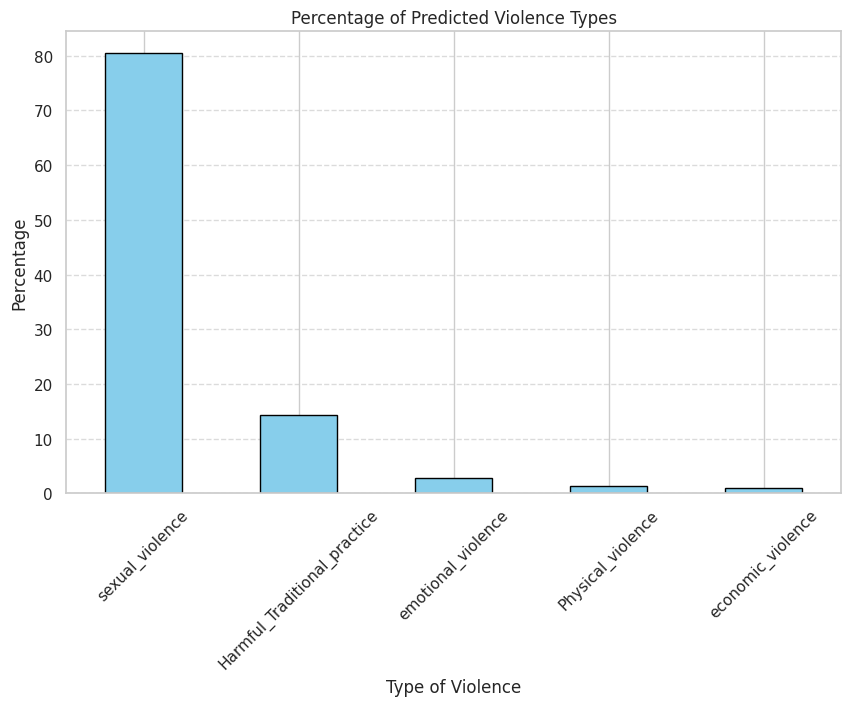

✅ Percentage of each predicted type:
predicted_type
sexual_violence                 80.44
Harmful_Traditional_practice    14.41
emotional_violence               2.84
Physical_violence                1.35
economic_violence                0.96
Name: count, dtype: float64


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from joblib import load
import os

# ----------------------------
# Load Test Data
# ----------------------------
test_data_path = "/content/drive/My Drive/Colab Notebooks/Test.csv"
test_data = pd.read_csv(test_data_path)

# Clean the tweets
test_data['cleaned_text'] = test_data['tweet'].apply(clean_and_convert_text)
test_data['cleaned_text'] = test_data['cleaned_text'].apply(lambda x: ' '.join(map(str, x)) if isinstance(x, list) else str(x))

# ----------------------------
# Load Saved Model and Vectorizer
# ----------------------------
model_dir = "/content/drive/My Drive/Colab Notebooks/Models"
NB_model_path = os.path.join(model_dir, "naive_bayes_model.joblib")
vectorizer_path = os.path.join(model_dir, "tfidf_vectorizer.joblib")

loaded_model = load(NB_model_path)
loaded_vectorizer = load(vectorizer_path)

# ----------------------------
# Transform Test Data
# ----------------------------
X_test_vec = loaded_vectorizer.transform(test_data['cleaned_text'])

# ----------------------------
# Predict Violence Types
# ----------------------------
test_data['predicted_type'] = loaded_model.predict(X_test_vec)

# Save predictions
output_path = "/content/drive/My Drive/Colab Notebooks/Test_with_predictions-NB-SMOTE.csv"
test_data.to_csv(output_path, index=False)
print(f"✅ Predictions saved successfully at: {output_path}")

# ----------------------------
# Visualize Results
# ----------------------------
type_counts = test_data['predicted_type'].value_counts()
type_percentages = (type_counts / type_counts.sum()) * 100

plt.figure(figsize=(10, 6))
type_percentages.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Percentage of Predicted Violence Types')
plt.xlabel('Type of Violence')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("✅ Percentage of each predicted type:")
print(type_percentages.round(2))


In [27]:
!pip install wordcloud



🧼 Sample cleaned tweets:
                                               tweet  \
0  Had a dream i got raped last night. By a guy i...   
1  he thought the word raped means sex and told m...   
2  She NOT TALKING TO ME I WAS RAPED BY 2 MEN 1 M...   
3  I was sexually abused for 3 years at age 4 to ...   
4  Chessy Prout can do better by telling the trut...   

                                        cleaned_text  
0  had a dream i got raped last night by a guy i ...  
1  he thought the word raped means sex and told m...  
2  she not talking to me i was raped by men moles...  
3  i was sexually abused for years at age to no o...  
4  chessy prout can do better by telling the trut...  

🔍 Checking class balance:
type
sexual_violence                 32648
Physical_violence                5946
emotional_violence                651
economic_violence                 217
Harmful_Traditional_practice      188
Name: count, dtype: int64


/tmp/ipython-input-1206091066.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_data, x='type', palette='viridis')


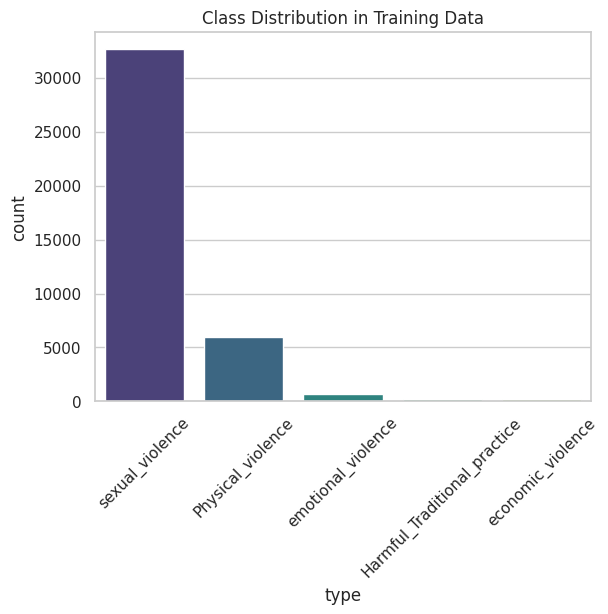

In [28]:
def clean_text(text):
    """
    Cleans tweet text by removing URLs, mentions, hashtags,
    punctuation, and normalizing whitespace.
    """
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)      # Remove URLs
    text = re.sub(r'@\w+', '', text)                # Remove @mentions
    text = re.sub(r'#[A-Za-z0-9_]+', '', text)      # Remove hashtags
    text = re.sub(r'[^a-z\s]', ' ', text)           # Remove punctuation and numbers
    text = re.sub(r'\s+', ' ', text).strip()        # Normalize whitespace
    return text

# Apply cleaning
train_data['cleaned_text'] = train_data['tweet'].astype(str).apply(clean_text)

print("\n🧼 Sample cleaned tweets:")
print(train_data[['tweet', 'cleaned_text']].head())


print("\n🔍 Checking class balance:")
print(train_data['type'].value_counts())

sns.countplot(data=train_data, x='type', palette='viridis')
plt.title("Class Distribution in Training Data")
plt.xticks(rotation=45)
plt.show()


In [29]:
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix
import numpy as np

# ===============================
# 🧩 Define Feature Extraction Function
# ===============================
def text_features(texts):
    features = []
    for t in texts:
        # Safety: ensure t is string
        t = str(t)
        blob = TextBlob(t)
        words = t.split()

        num_words = len(words)
        avg_len = np.mean([len(w) for w in words]) if words else 0
        sentiment = blob.sentiment.polarity
        exclam = t.count('!')
        caps = sum(1 for w in words if w.isupper())

        features.append([num_words, avg_len, sentiment, exclam, caps])
    return np.array(features, dtype=float)

# ===============================
# 🧮 TF-IDF Vectorization + Numeric Features
# ===============================
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),        # unigrams + bigrams
    max_features=20000,        # limit vocabulary for efficiency
    stop_words='english'
)

X_tfidf = vectorizer.fit_transform(train_data['cleaned_text'])
extra_features = text_features(train_data['cleaned_text'])

# Scale numeric features
scaler = StandardScaler(with_mean=False)  # with_mean=False since we'll combine with sparse data
extra_scaled = scaler.fit_transform(extra_features)

# Combine TF-IDF and numeric features into one feature matrix
X_combined = hstack([X_tfidf, csr_matrix(extra_scaled)])

# Labels
y = train_data['type']

print(f"✅ Combined feature matrix shape: {X_combined.shape}")


✅ Combined feature matrix shape: (39650, 20005)


In [31]:
print("🧩 X_combined shape:", X_combined.shape)

🧩 X_combined shape: (39650, 20005)


===== BASE LOGISTIC REGRESSION =====
                              precision    recall  f1-score   support

Harmful_Traditional_practice     1.0000    0.9737    0.9867        38
           Physical_violence     0.9958    0.9933    0.9945      1189
           economic_violence     0.9130    0.9767    0.9438        43
          emotional_violence     0.9774    1.0000    0.9886       130
             sexual_violence     0.9985    0.9982    0.9983      6530

                    accuracy                         0.9972      7930
                   macro avg     0.9769    0.9884    0.9824      7930
                weighted avg     0.9973    0.9972    0.9972      7930


===== GRID SEARCH TUNING =====
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'C': 10, 'solver': 'liblinear'}
                              precision    recall  f1-score   support

Harmful_Traditional_practice     1.0000    1.0000    1.0000        38
           Physical_violence     0.9958    0.9

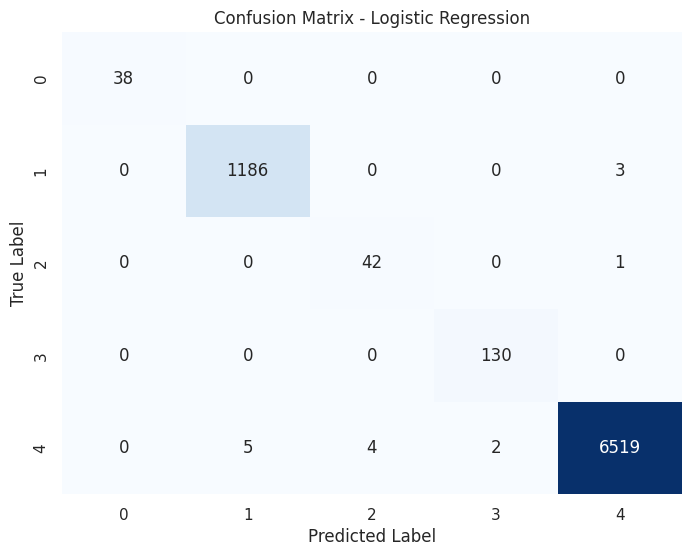


ROC-AUC Score (OVR): 0.9999
Coef shape: (5, 20005)


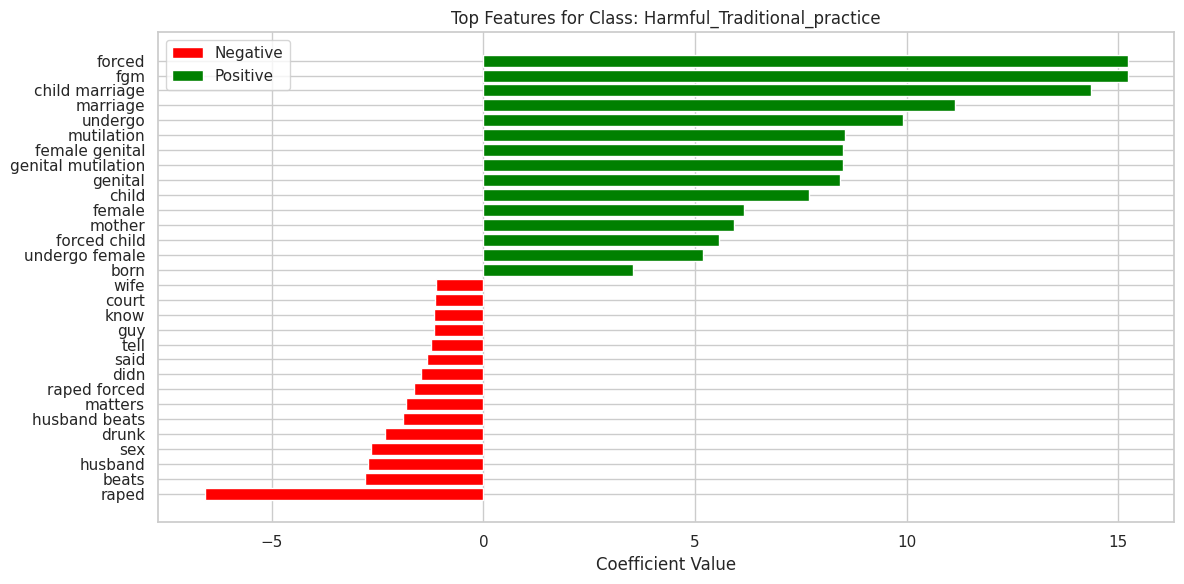

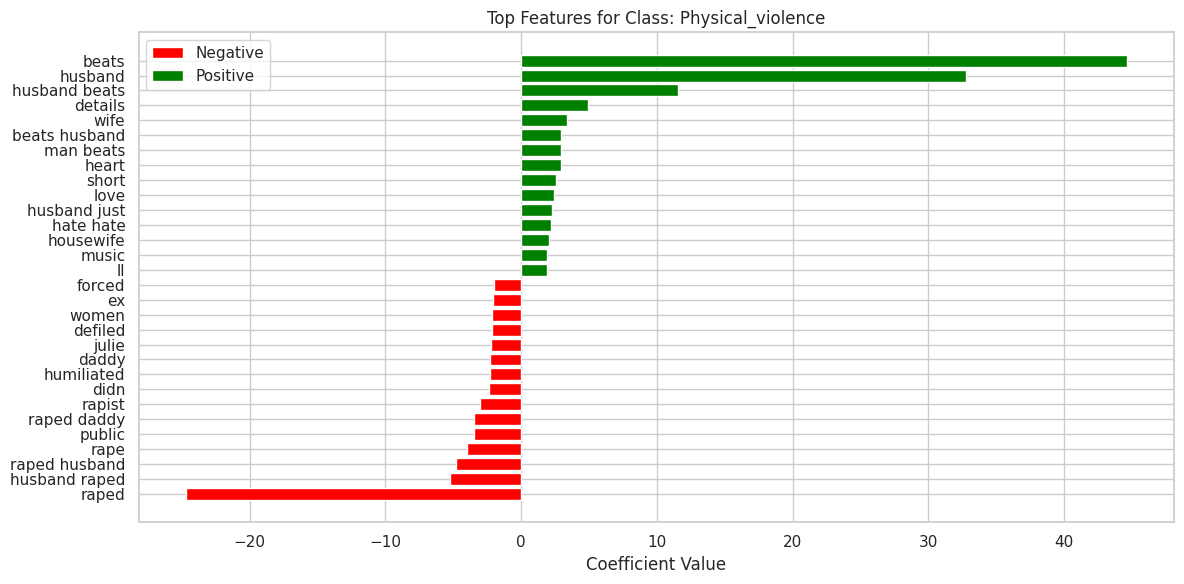

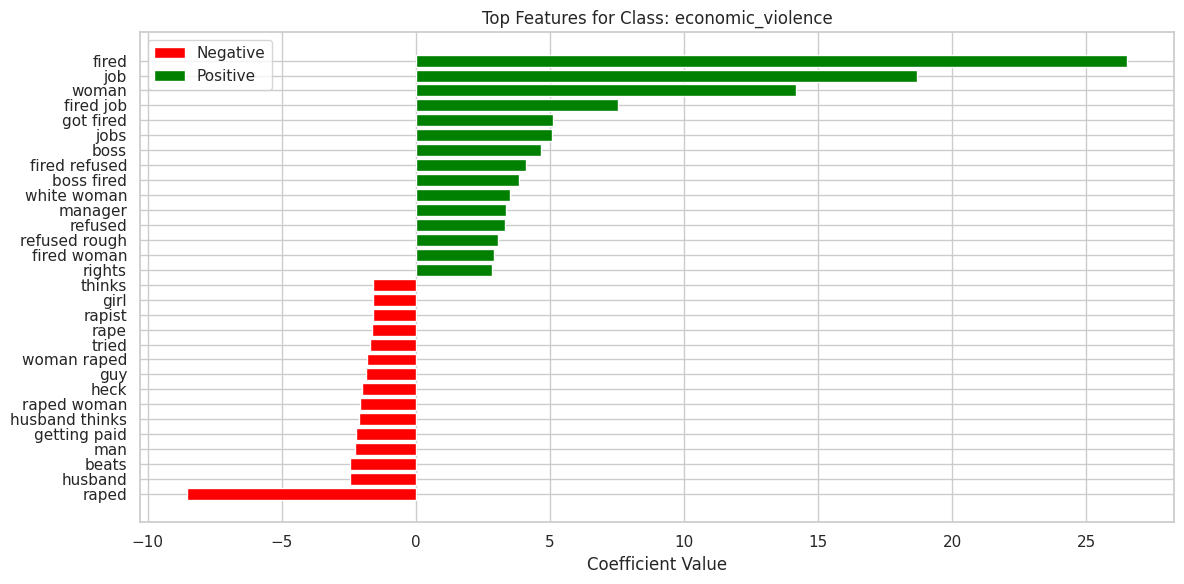

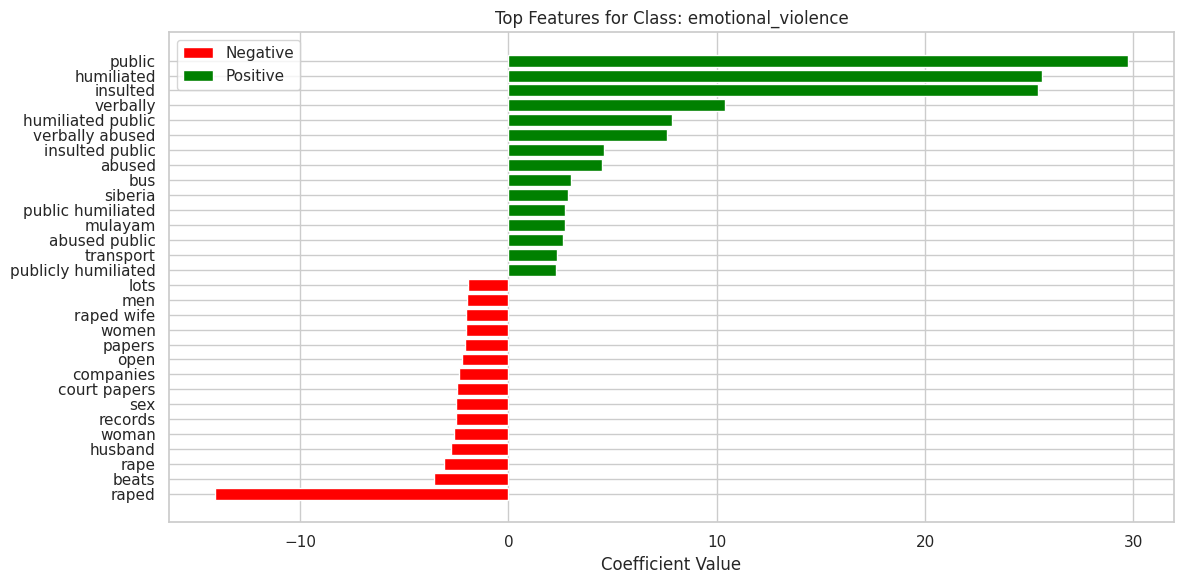

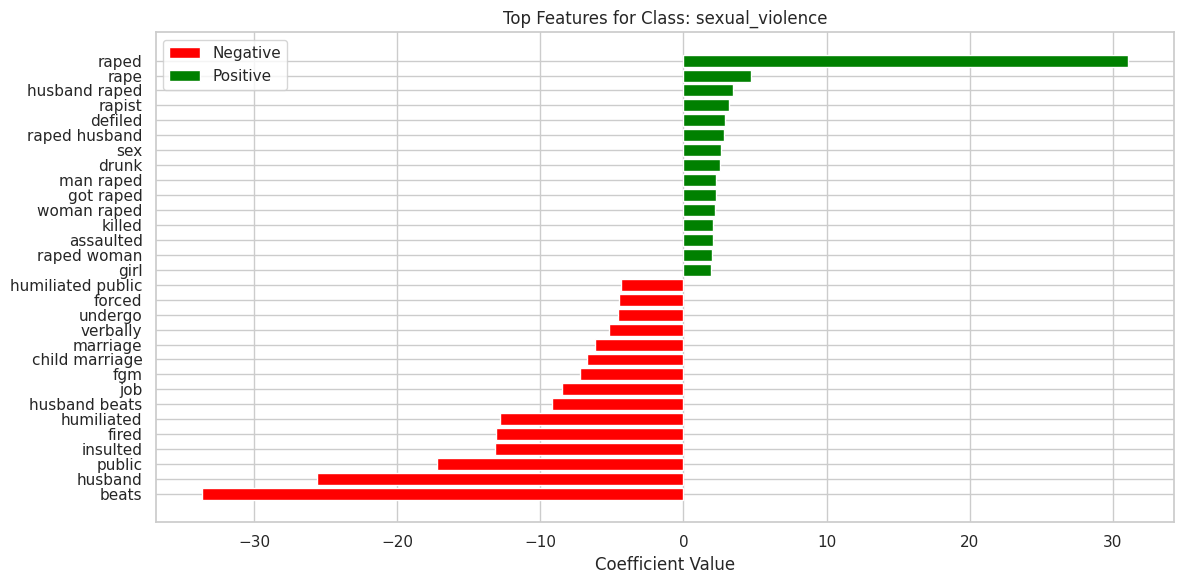

🧠 Coefficients length (first class): 20005


In [32]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ==============================
# 🧩 Split Data (Ensure Stratification)
# ==============================
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y
)

# ==============================
# ⚙️ Logistic Regression (Base Model)
# ==============================
print("===== BASE LOGISTIC REGRESSION =====")
base_lr = LogisticRegression(max_iter=2000, class_weight='balanced', solver='liblinear')
base_lr.fit(X_train, y_train)
y_pred_base = base_lr.predict(X_test)

print(classification_report(y_test, y_pred_base, digits=4))

# ==============================
# 🔍 Hyperparameter Tuning (GridSearchCV)
# ==============================
print("\n===== GRID SEARCH TUNING =====")
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga']
}
grid = GridSearchCV(
    LogisticRegression(max_iter=2000, class_weight='balanced'),
    param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)

best_lr = grid.best_estimator_
y_pred_lr = best_lr.predict(X_test)

print("Best Parameters:", grid.best_params_)
print(classification_report(y_test, y_pred_lr, digits=4))

# ==============================
# 📊 Confusion Matrix Visualization
# ==============================
cm = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ==============================
# 🎯 ROC-AUC (for multiclass average)
# ==============================
try:
    y_prob = best_lr.predict_proba(X_test)
    auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
    print(f"\nROC-AUC Score (OVR): {auc:.4f}")
except Exception as e:
    print("ROC-AUC not applicable for this dataset:", e)

# ==============================
# 💡 Feature Importance Visualization
# ==============================
# Define feature names
tfidf_feature_names = vectorizer.get_feature_names_out()
n_tfidf = len(tfidf_feature_names)
n_total = X_combined.shape[1]
n_extra = n_total - n_tfidf

# Only include exactly the correct number of extra features
extra_feature_names = ['num_words', 'avg_len', 'sentiment', 'exclam', 'caps', 'emoji_count', 'noun_ratio', 'verb_ratio']
extra_feature_names = extra_feature_names[:n_extra]  # slice to match X_combined
all_feature_names = np.concatenate([tfidf_feature_names, extra_feature_names])

# Confirm shape
print("Coef shape:", best_lr.coef_.shape)  # (n_classes, n_features)
n_classes, n_features = best_lr.coef_.shape

# Make sure feature_names length matches
assert len(all_feature_names) == n_features, "Mismatch between features and coefficients!"
feature_names = all_feature_names

# Plot top positive and negative features per class
for class_idx in range(n_classes):
    coefs = best_lr.coef_[class_idx]
    top_positive_idx = np.argsort(coefs)[-15:]
    top_negative_idx = np.argsort(coefs)[:15]

    plt.figure(figsize=(12, 6))
    plt.barh(feature_names[top_negative_idx], coefs[top_negative_idx], color='red', label='Negative')
    plt.barh(feature_names[top_positive_idx], coefs[top_positive_idx], color='green', label='Positive')
    plt.title(f"Top Features for Class: {best_lr.classes_[class_idx]}")
    plt.xlabel("Coefficient Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Optional: print first class coefficients length
coefs = best_lr.coef_[0]
print("🧠 Coefficients length (first class):", len(coefs))


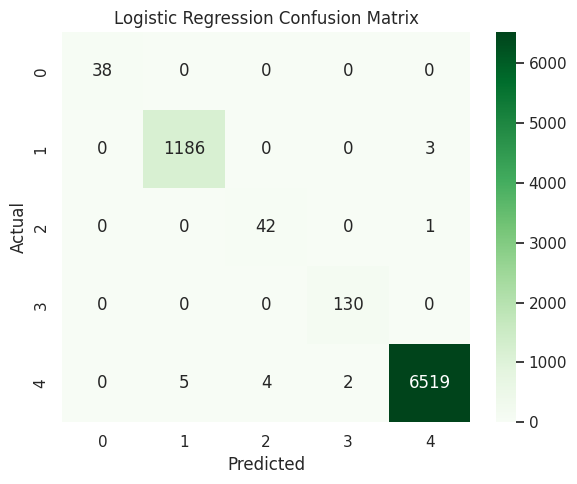

In [33]:
#confusion matrix
plt.figure(figsize=(6,5))

sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap='Greens')
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.tight_layout()
plt.show()

In [34]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Check if model can output probabilities
if hasattr(best_lr, "predict_proba"):
    probs_lr = best_lr.predict_proba(X_test)

    # Binarize labels for multiclass AUC computation
    y_test_binarized = label_binarize(y_test, classes=best_lr.classes_)

    # Compute macro-average AUC-ROC
    auc_macro = roc_auc_score(y_test_binarized, probs_lr, average="macro")
    print(f"✅ Macro-average ROC-AUC (Logistic Regression): {auc_macro:.4f}")
else:
    print("⚠️ Logistic Regression model does not have a predict_proba method.")


✅ Macro-average ROC-AUC (Logistic Regression): 0.9999


In [35]:
import nltk

# Download both versions of the POS tagger (fixes all variants)
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

# Optional: also grab related data for robustness
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')



[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [36]:

# Enhanced feature extraction
def text_features(texts):
    features = []
    nltk.download('averaged_perceptron_tagger', quiet=True)

    for t in texts:
        blob = TextBlob(t)
        words = t.split()
        num_words = len(words)
        avg_len = np.mean([len(w) for w in words]) if words else 0
        sentiment = blob.sentiment.polarity
        exclam = t.count('!')
        caps = sum(1 for w in words if w.isupper())

        # Emoji sentiment & POS tag ratio
        emoji_count = emoji.emoji_count(t)
        pos_tags = nltk.pos_tag(words)
        noun_ratio = sum(1 for w, p in pos_tags if p.startswith('NN')) / num_words if num_words else 0
        verb_ratio = sum(1 for w, p in pos_tags if p.startswith('VB')) / num_words if num_words else 0

        features.append([num_words, avg_len, sentiment, exclam, caps, emoji_count, noun_ratio, verb_ratio])
    return np.array(features)

# TF-IDF + numeric features
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=20000, stop_words='english')
X_tfidf = vectorizer.fit_transform(train_data['cleaned_text'])
extra_features = text_features(train_data['cleaned_text'])

scaler = StandardScaler()
extra_scaled = scaler.fit_transform(extra_features)

X_combined = hstack([X_tfidf, csr_matrix(extra_scaled)])
y = train_data['type']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y
)

# Save text for LIME
X_text_train = train_data.loc[y_train.index, 'cleaned_text'].values
X_text_test = train_data.loc[y_test.index, 'cleaned_text'].values

print(f"✅ Data ready: {X_train.shape[0]} train samples, {X_test.shape[0]} test samples.")


✅ Data ready: 31720 train samples, 7930 test samples.


In [38]:
#  LIME Explainability Section

!pip install lime

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from lime.lime_text import LimeTextExplainer
from scipy.sparse import hstack, csr_matrix
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from textblob import TextBlob

print(" Starting LIME Explanation Example...")

# --- Train Logistic Regression with GridSearchCV ---
log_reg = LogisticRegression(max_iter=2000, class_weight='balanced', solver='lbfgs')

# Hyperparameter tuning
param_grid = {'C': [0.01, 0.1, 1, 10]}
grid = GridSearchCV(
    log_reg,
    param_grid,
    cv=3,
    scoring='f1_weighted',  # good for imbalanced multi-class data
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

# Get the best model
best_lr = grid.best_estimator_
print(f"\n✅ Best Logistic Regression Parameters: {grid.best_params_}")
print(f"✅ Best Weighted F1 Score: {grid.best_score_:.4f}")

# --- Define class names (from the model) ---
class_names = best_lr.classes_.tolist()
print(f"\nDetected Classes: {class_names}")

# --- Define LIME Text Explainer ---
explainer = LimeTextExplainer(class_names=class_names)

# --- Prediction wrapper for LIME ---
def predict_proba_for_lime(texts):
    """
    This function cleans input text, extracts TF-IDF + custom features,
    scales them, and returns predicted probabilities for each class.
    """
    cleaned_texts = [clean_text(t) for t in texts]  # ensure consistent cleaning
    tfidf = vectorizer.transform(cleaned_texts)
    stats = text_features(cleaned_texts)
    scaled = scaler.transform(stats)
    combined = hstack([tfidf, csr_matrix(scaled)])
    return best_lr.predict_proba(combined)

# --- Pick a sample tweet to explain ---
idx = 5  # you can change to any other index to explore
tweet_example = X_text_test[idx]
print(f"\n🧾 Sample Tweet (index {idx}):\n{tweet_example}\n")

# --- Generate explanation ---
lime_exp = explainer.explain_instance(
    tweet_example,
    predict_proba_for_lime,
    num_features=10,
    labels=[0, 1, 2]  # optional: specify labels if you have 3 classes, else remove
)

# --- Display results ---
print("\n📊 Top Influential Words and Their Impact:")
for feature, weight in lime_exp.as_list():
    print(f"{feature:25s} {weight:+.4f}")

# --- Visualization ---
try:
    lime_exp.show_in_notebook(text=True)
except:
    print("\n⚠️ Inline visualization failed (Colab issue). Saving HTML file instead...")

lime_exp.save_to_file('/content/lime_explanation.html')
print("\n✅ LIME explanation saved to: lime_explanation.html (Download from Colab sidebar)")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=09fde1eecbe5a361422cf00828c1590ea38b28896a1523e7a88550d8ea6af5f9
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime
 Starting LIME Explanation Example...
Fitting 3 folds for each of 4 candidates, totalling 12 fits

✅ Best Logistic Regression Parameters: {'C': 10}
✅ Best Weighted F1 Score: 0.9976

Detected Classes: ['Harmful_Traditional_practice', 'Physical_violence', 'economic_violence', 'emotional_violence', 'sexual_violence']

🧾 Sample Tweet (index 5):
my husband doesn t pray drinks beats me woman tells court


📊 Top Influential Words and Their Impact:
husband                   +0.1512
beats                     +0.1491
tells                     +0.0383
drinks                    +0.0332
me               


✅ LIME explanation saved to: lime_explanation.html (Download from Colab sidebar)


In [5]:
!pip install shap textblob emoji --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix
from textblob import TextBlob
import nltk
import emoji
import re
import shap

print("✅ Libraries loaded")


✅ Libraries loaded


In [3]:
import pandas as pd
import re # Added this import statement

train_data_path = "/content/drive/My Drive/Colab Notebooks/Train.csv"
train_data = pd.read_csv(train_data_path)

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#[A-Za-z0-9_]+', '', text)
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

train_data['cleaned_text'] = train_data['tweet'].astype(str).apply(clean_text)

In [7]:
import nltk # Added this import
import numpy as np # Added this import to ensure numpy is available for np.mean
import emoji # Added this import as emoji is used in text_features
from textblob import TextBlob # Added this import as TextBlob is used

# ----------------------
# Feature extraction
# ----------------------
def text_features(texts):
    features = []
    nltk.download('averaged_perceptron_tagger', quiet=True)
    for t in texts:
        t = str(t)
        blob = TextBlob(t)
        words = t.split()
        num_words = len(words)
        avg_len = np.mean([len(w) for w in words]) if words else 0
        sentiment = blob.sentiment.polarity
        exclam = t.count('!')
        caps = sum(1 for w in words if w.isupper())
        emoji_count = emoji.emoji_count(t)
        pos_tags = nltk.pos_tag(words)
        noun_ratio = sum(1 for w, p in pos_tags if p.startswith('NN')) / num_words if num_words else 0
        verb_ratio = sum(1 for w, p in pos_tags if p.startswith('VB')) / num_words if num_words else 0
        features.append([num_words, avg_len, sentiment, exclam, caps, emoji_count, noun_ratio, verb_ratio])
    return np.array(features)

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# ----------------------
# TF-IDF + Numeric features
# ----------------------
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=20000, stop_words='english')
X_tfidf = vectorizer.fit_transform(train_data['cleaned_text'])
extra_features = text_features(train_data['cleaned_text'])
scaler = StandardScaler(with_mean=False)
extra_scaled = scaler.fit_transform(extra_features)

X_combined = hstack([X_tfidf, csr_matrix(extra_scaled)])
y = train_data['type']

# ----------------------
# Train/Test Split
# ----------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y
)

# ----------------------
# Train Logistic Regression
# ----------------------
print("\n===== Training Logistic Regression =====")
lr_model = LogisticRegression(max_iter=2000, class_weight='balanced', solver='liblinear')
lr_model.fit(X_train, y_train)
print("✅ Logistic Regression trained successfully.")


===== Training Logistic Regression =====
✅ Logistic Regression trained successfully.


In [9]:
import shap

# ----------------------
# Prepare SHAP Explainer
# ----------------------
sample_size = 100
X_bg = X_train[:sample_size]
X_sample = X_test[:50]

if hasattr(X_bg, "toarray"): X_bg = X_bg.toarray()
if hasattr(X_sample, "toarray"): X_sample = X_sample.toarray()

explainer_shap = shap.LinearExplainer(lr_model, X_bg, feature_perturbation="interventional")
shap_values = explainer_shap.shap_values(X_sample)


/usr/local/lib/python3.12/dist-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)



Generating SHAP summary plot...


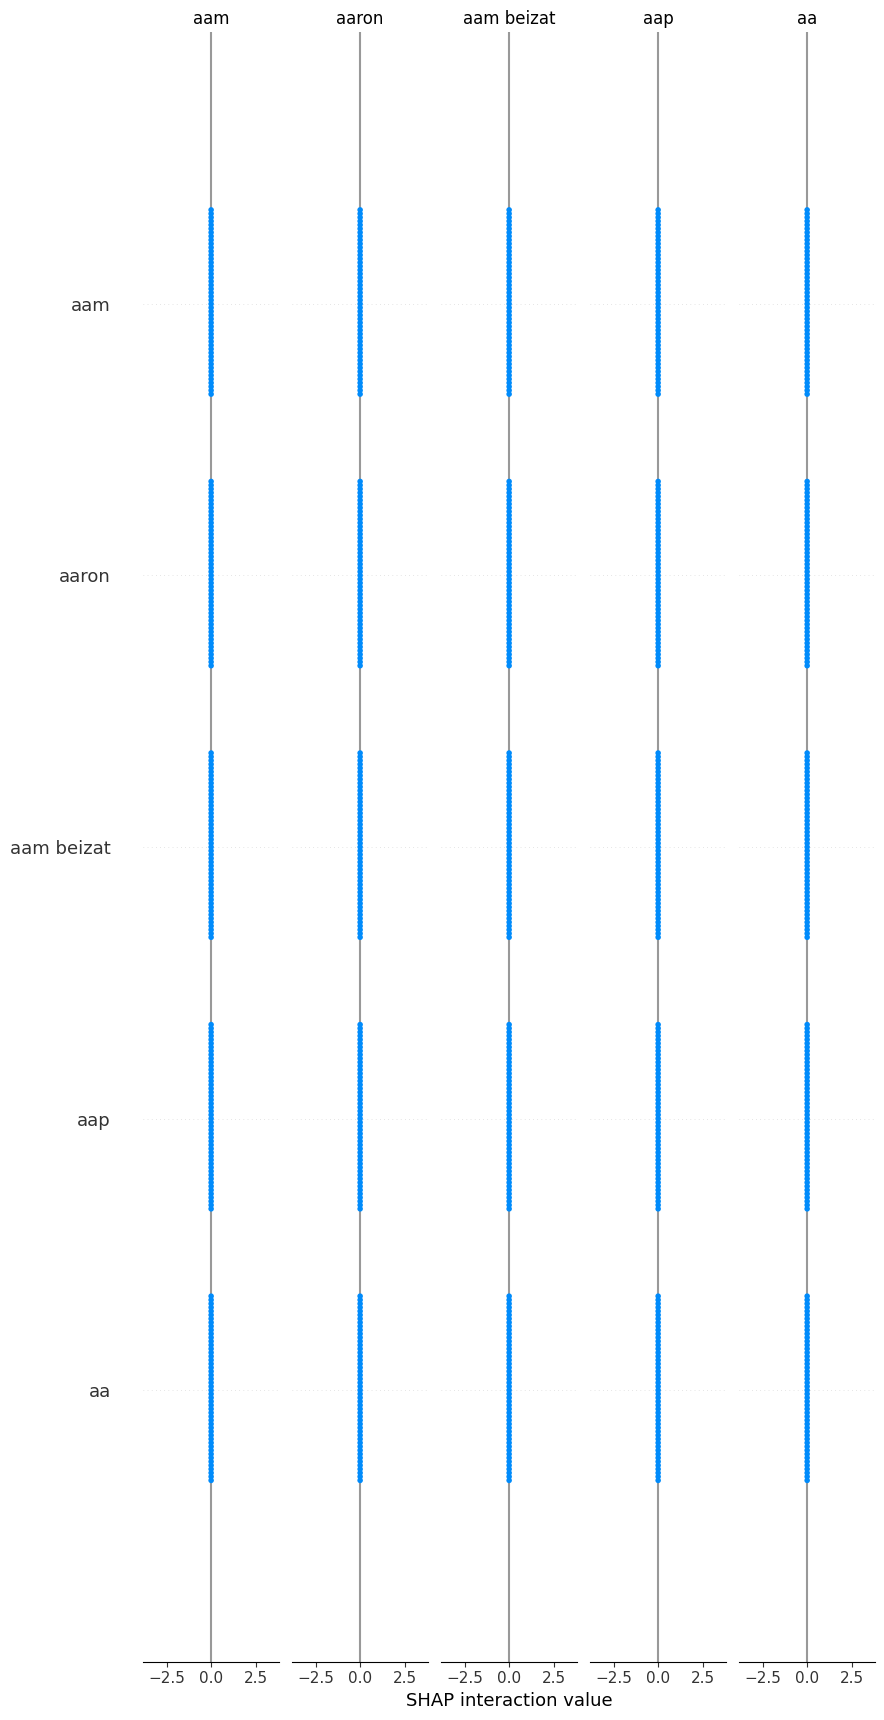

In [10]:
# ----------------------
# Feature Names
# ----------------------
tfidf_feature_names = vectorizer.get_feature_names_out()
extra_feature_names = ['num_words', 'avg_len', 'sentiment', 'exclam', 'caps', 'emoji_count', 'noun_ratio', 'verb_ratio']
n_tfidf = len(tfidf_feature_names)
n_total = X_combined.shape[1]
n_extra = n_total - n_tfidf
extra_feature_names = extra_feature_names[:n_extra]
all_feature_names = np.concatenate([tfidf_feature_names, extra_feature_names])
assert len(all_feature_names) == X_combined.shape[1], "Mismatch between features and coefficients!"

# ----------------------
# SHAP Global Summary Plot
# ----------------------
print("\nGenerating SHAP summary plot...")
shap.summary_plot(
    shap_values,
    X_sample,
    feature_names=all_feature_names,
    max_display=20,
    show=True
)


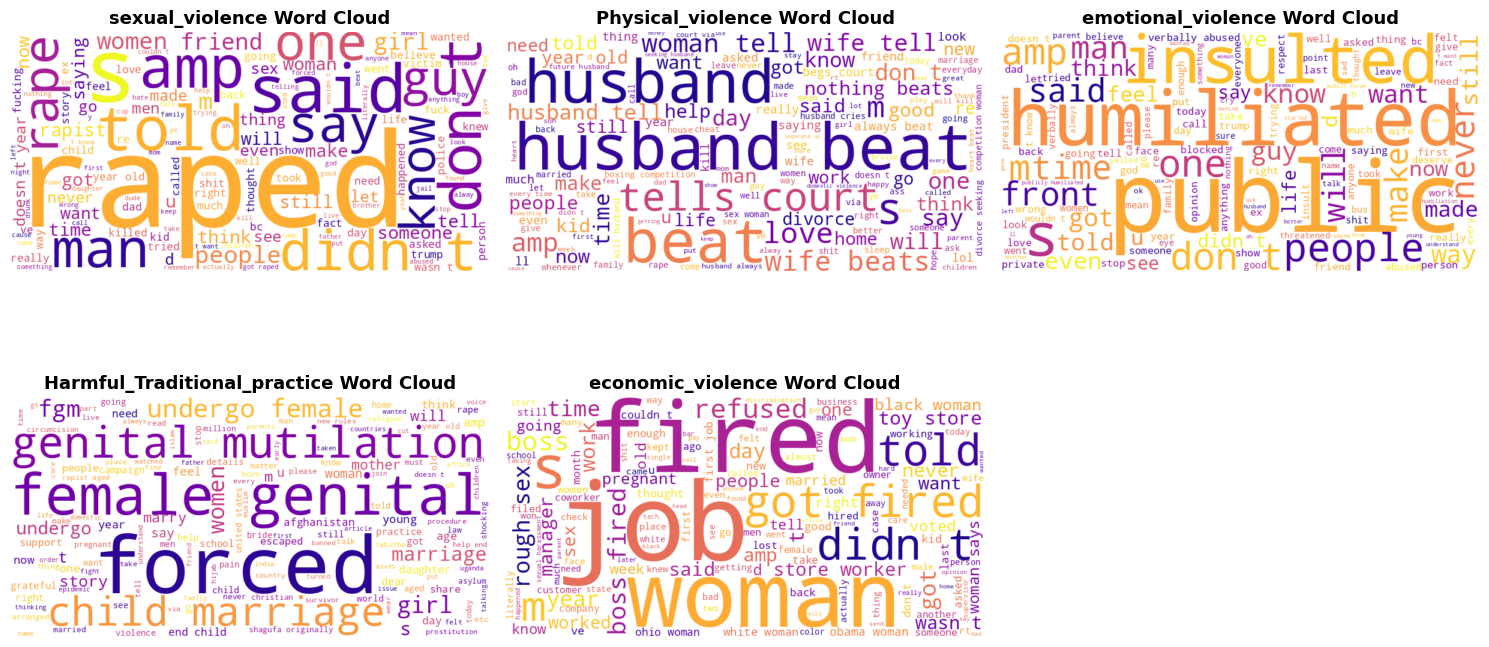

In [4]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Ensure required columns exist
if 'type' not in train_data.columns or 'cleaned_text' not in train_data.columns:
    raise KeyError("train_data must contain 'type' and 'cleaned_text' columns.")

# Create a dictionary to store combined text for each violence type
combined_text_by_type = {}

for violence_type in train_data['type'].dropna().unique():
    type_texts = train_data.loc[train_data['type'] == violence_type, 'cleaned_text'].dropna().astype(str)
    combined_text_by_type[violence_type] = " ".join(type_texts)

# Generate and plot word clouds
n_types = len(combined_text_by_type)
cols = 3
rows = (n_types + cols - 1) // cols  # Adjust grid dynamically

plt.figure(figsize=(5 * cols, 4 * rows))

for i, (violence_type, combined_text) in enumerate(combined_text_by_type.items()):
    # Generate word cloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color="white",  # Change to "black" for dark mode
        colormap="plasma",         # Alternative colormap
        stopwords=STOPWORDS,       # Remove common words
        max_words=150,             # Limit for clarity
        contour_color='steelblue', # Aesthetic outline
        contour_width=1
    ).generate(combined_text)

    # Plot
    plt.subplot(rows, cols, i + 1)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"{violence_type} Word Cloud", fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()


In [5]:
wordcloud.to_file(f"{violence_type}_wordcloud.png")

In [6]:
from collections import Counter
words = combined_text.split()
top_words = Counter(words).most_common(10)
print(f"Top words for {violence_type}:", top_words)

Top words for economic_violence: [('i', 614), ('a', 366), ('was', 360), ('because', 257), ('my', 232), ('fired', 228), ('job', 208), ('to', 208), ('the', 206), ('woman', 202)]


In [14]:
import pandas as pd
import re

# Define paths (assuming this path is still correct)
train_path = "/content/drive/My Drive/Colab Notebooks/Train.csv"

# Load train_df and define df
train_df = pd.read_csv(train_path, encoding="utf-8")
df = train_df.copy()

# --- 1′′ Rename column if needed ---
df.rename(columns={'tweet': 'text_clean'}, inplace=True)

# --- 2′′ Clean text function ---
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+', '', text)   # remove URLs
    text = re.sub(r'@\w+', '', text)      # remove mentions
    text = re.sub(r'#\w+', '', text)      # remove hashtags
    text = re.sub(r'[^a-z\s]', '', text)  # remove punctuation & digits
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['text_clean'] = df['text_clean'].apply(clean_text)

In [15]:

# --- 3️⃣ Install and import dependencies ---
!pip install -q vaderSentiment textblob better-profanity nrclex nltk

import numpy as np
import pandas as pd
import nltk
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from better_profanity import profanity
from nrclex import NRCLex
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# --- 4️⃣ Download NLTK resources ---
nltk.download('punkt')
nltk.download('stopwords')

# --- 5️⃣ Check dataframe presence ---
try:
    df
except NameError:
    try:
        df = data.copy()
        print("📂 Using 'data' as the base DataFrame.")
    except NameError:
        raise NameError("❌ No DataFrame found. Please load your dataset first into 'df' or 'data'.")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:

# --- 6️⃣ Verify text column ---
if 'text_clean' not in df.columns:
    raise KeyError("❌ Column 'text_clean' not found. Please ensure your cleaned tweet text column exists.")

# --- 7️⃣ Initialize analyzers and regex patterns ---
analyzer = SentimentIntensityAnalyzer()
profanity.load_censor_words()

gender_terms = re.compile(r'\b(he|she|him|her|his|hers|woman|man|girl|boy|lady|guy|female|male|wife|husband)\b', re.I)
aggressive_terms = re.compile(r'\b(kill|beat|slap|rape|hurt|harass|abuse|molest|attack|assault|threat|die|death|shame|insult|mock|torture)\b', re.I)

# --- 8️⃣ Helper functions ---
def safe_tokenize(text):
    """Tokenize safely with fallback."""
    try:
        return word_tokenize(str(text).lower())
    except Exception:
        return []

def count_vulgar(text):
    words = safe_tokenize(text)
    return sum(profanity.contains_profanity(w) for w in words)

def count_gender_terms(text):
    return len(re.findall(gender_terms, str(text)))

def count_aggressive_terms(text):
    return len(re.findall(aggressive_terms, str(text)))

def extract_emotions(text):
    """Detect dominant emotion using NRCLex; fallback to neutral."""
    try:
        emotions = NRCLex(str(text))
        scores = emotions.raw_emotion_scores
        return max(scores, key=scores.get) if scores else 'neutral'
    except Exception:
        return 'neutral'

# --- 9️⃣ Feature extraction main function ---
def extract_features(df, text_col):
    df = df.copy()
    print("⚙️ Extracting linguistic & emotional features...")

    df[text_col] = df[text_col].astype(str).fillna("")

    # Basic metrics
    df["text_len"] = df[text_col].apply(len)
    df["word_count"] = df[text_col].apply(lambda x: len(x.split()))
    df["avg_word_len"] = df[text_col].apply(
        lambda x: np.mean([len(w) for w in x.split()]) if len(x.split()) > 0 else 0
    )
    df["num_uppercase"] = df[text_col].apply(lambda x: sum(1 for w in x.split() if w.isupper()))
    df["num_exclamation"] = df[text_col].apply(lambda x: x.count("!"))
    df["num_question"] = df[text_col].apply(lambda x: x.count("?"))

    # Advanced linguistic & sentiment metrics
    df["num_vulgar"] = df[text_col].apply(count_vulgar)
    df["num_pronouns"] = df[text_col].apply(count_gender_terms)
    df["num_aggressive"] = df[text_col].apply(count_aggressive_terms)
    df["vader_sentiment"] = df[text_col].apply(lambda x: analyzer.polarity_scores(x)["compound"])
    df["polarity"] = df[text_col].apply(lambda x: TextBlob(x).sentiment.polarity)
    df["subjectivity"] = df[text_col].apply(lambda x: TextBlob(x).sentiment.subjectivity)

    # Emotions
    df["dominant_emotion"] = df[text_col].apply(extract_emotions)
    df = pd.get_dummies(df, columns=["dominant_emotion"], prefix="emo")

    print("✅ Feature extraction complete!")
    return df

# --- 🔟 Apply feature extraction ---
df_features = extract_features(df, "text_clean")

print("\n✅ Feature engineering complete. Sample columns:")
print(df_features.columns.tolist())
df_features.head(3)


⚙️ Extracting linguistic & emotional features...
✅ Feature extraction complete!

✅ Feature engineering complete. Sample columns:
['Tweet_ID', 'text_clean', 'type', 'text_len', 'word_count', 'avg_word_len', 'num_uppercase', 'num_exclamation', 'num_question', 'num_vulgar', 'num_pronouns', 'num_aggressive', 'vader_sentiment', 'polarity', 'subjectivity', 'emo_anger', 'emo_anticipation', 'emo_disgust', 'emo_fear', 'emo_joy', 'emo_negative', 'emo_neutral', 'emo_positive', 'emo_sadness', 'emo_surprise', 'emo_trust']


,Tweet_ID,text_clean,type,text_len,word_count,avg_word_len,num_uppercase,num_exclamation,num_question,num_vulgar,...,emo_anticipation,emo_disgust,emo_fear,emo_joy,emo_negative,emo_neutral,emo_positive,emo_sadness,emo_surprise,emo_trust
0,ID_0022DWKP,had a dream i got raped last night by a guy i ...,sexual_violence,199,45,3.444444,0,0,0,2,...,False,False,False,False,False,True,False,False,False,False
1,ID_00395QYM,he thought the word raped means sex and told m...,sexual_violence,98,21,3.714286,0,0,0,4,...,True,False,False,False,False,False,False,False,False,False
2,ID_003EOSSF,she not talking to me i was raped by men moles...,sexual_violence,100,22,3.590909,0,0,0,1,...,False,False,True,False,False,False,False,False,False,False


In [17]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.sparse import hstack, csr_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# --- 1️⃣ TF-IDF feature extraction ---
vectorizer = TfidfVectorizer(max_features=7000, ngram_range=(1, 2))
X_tfidf = vectorizer.fit_transform(df_features["text_clean"])

# --- 2️⃣ Select numeric engineered features ---
num_cols = df_features.select_dtypes(include=[np.number]).columns.tolist()
if "type" in num_cols:  # ensure target isn't included
    num_cols.remove("type")

# --- 3️⃣ Scale numeric features ---
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(df_features[num_cols])

# --- 4️⃣ Combine TF-IDF + engineered features ---
X_combined = hstack([X_tfidf, csr_matrix(X_num_scaled)])

# --- 5️⃣ Define target variable ---
y = df_features["type"]

# --- 6️⃣ Split into train/test sets ---
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y
)

# --- 7️⃣ Train Naive Bayes ---
# MultinomialNB expects non-negative features, so use MinMaxScaler (0–1 range)
minmax_scaler = MinMaxScaler()
X_train_scaled = minmax_scaler.fit_transform(X_train.toarray())
X_test_scaled = minmax_scaler.transform(X_test.toarray())

nb_model = MultinomialNB()
nb_model.fit(X_train_scaled, y_train)

# --- 8️⃣ Predictions + Evaluation ---
y_pred = nb_model.predict(X_test_scaled)

print("✅ Naive Bayes Model Performance")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred))



✅ Naive Bayes Model Performance
Accuracy: 0.9856

Classification Report:
                               precision    recall  f1-score   support

Harmful_Traditional_practice       1.00      0.74      0.85        38
           Physical_violence       0.99      0.94      0.97      1189
           economic_violence       1.00      0.77      0.87        43
          emotional_violence       0.99      0.88      0.93       130
             sexual_violence       0.98      1.00      0.99      6530

                    accuracy                           0.99      7930
                   macro avg       0.99      0.86      0.92      7930
                weighted avg       0.99      0.99      0.99      7930



In [18]:
# Save model and vectorizer for reuse
from joblib import dump
dump(nb_model, "naive_bayes_model.joblib")
dump(vectorizer, "tfidf_vectorizer.joblib")
dump(scaler, "feature_scaler.joblib")
dump(minmax_scaler, "minmax_scaler.joblib")

print("\n💾 Model, vectorizer, and scalers saved successfully.")


💾 Model, vectorizer, and scalers saved successfully.
